source: https://www.srose.biz/machine-learning/customer-segmentation-in-python/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np
import datetime as dt

In [2]:
online = pd.read_excel('Online Retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'])

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

In [7]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)
# Print top 5 rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,2,0.00
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

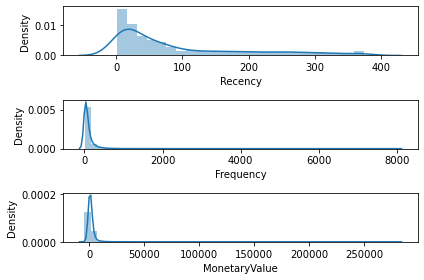

In [8]:
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

# Unskew the data
datamart_rfm = datamart_rfm[~datamart_rfm[datamart_rfm <= 0].any(1)]
datamart_log = np.log(datamart_rfm)
#datamart_log = datamart_log[~datamart_log.isin([np.nan, np.inf, -np.inf]).any(1)]

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, 
                                   columns=datamart_rfm.columns)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

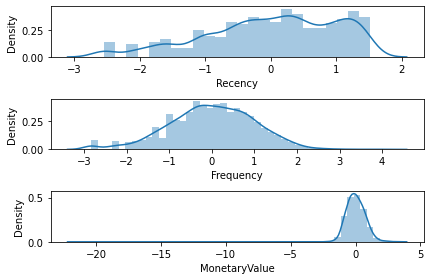

In [25]:
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.tight_layout()
plt.show()


In [26]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_


In [28]:
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)



Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          25.0     179.0        3720.3  1913
1         142.4      26.5         497.7  2404
2          69.8      56.0           0.0     5

In [29]:
sse = dict()

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_ 

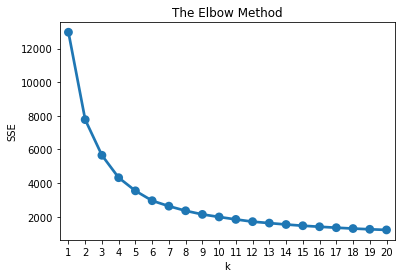

In [30]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.39269547758002493
For n_clusters = 3 The average silhouette_score is : 0.3987908082586018
For n_clusters = 4 The average silhouette_score is : 0.30746109675888184
For n_clusters = 5 The average silhouette_score is : 0.3141690181096069
For n_clusters = 6 The average silhouette_score is : 0.2932209895443063


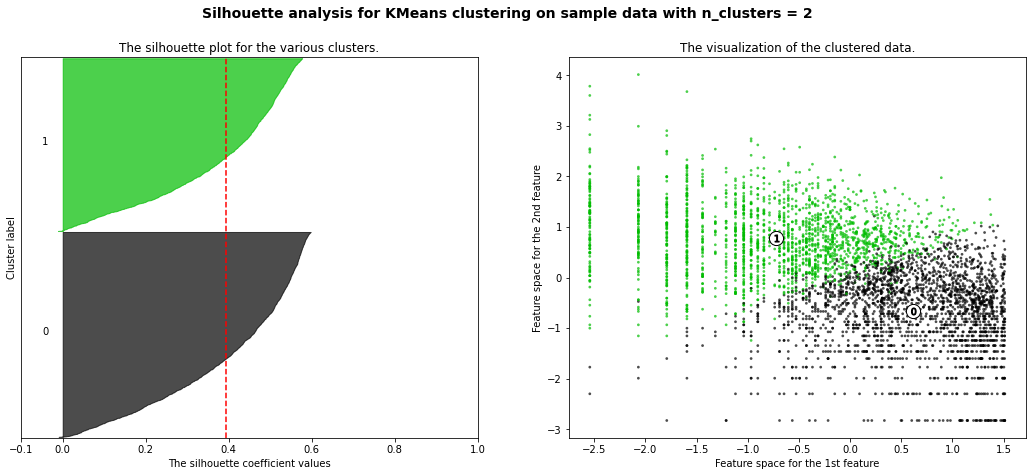

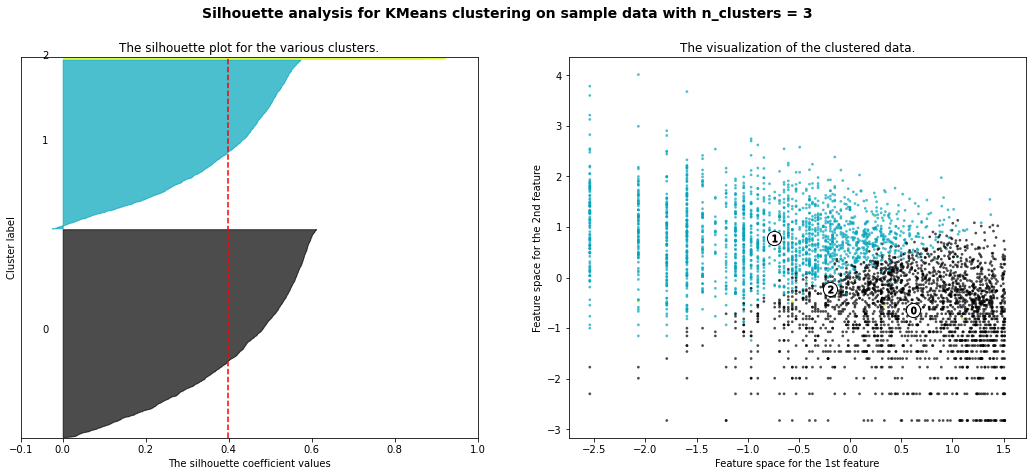

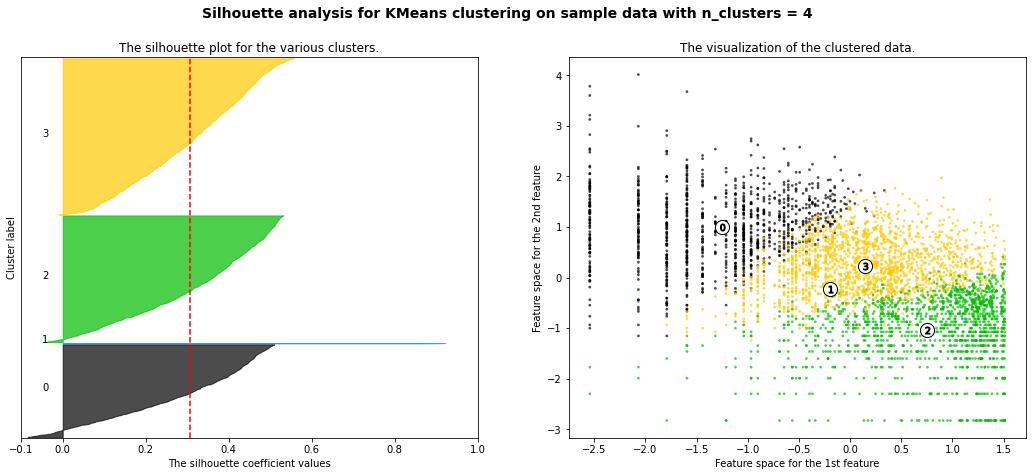

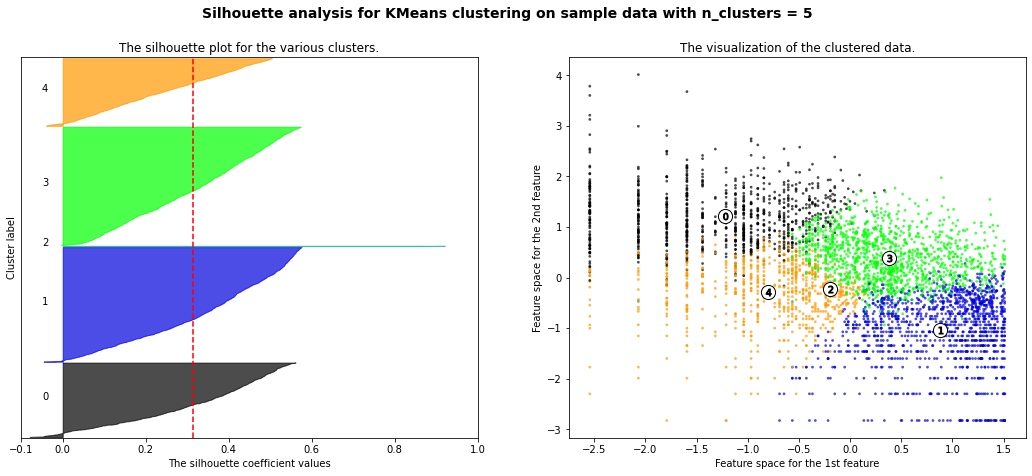

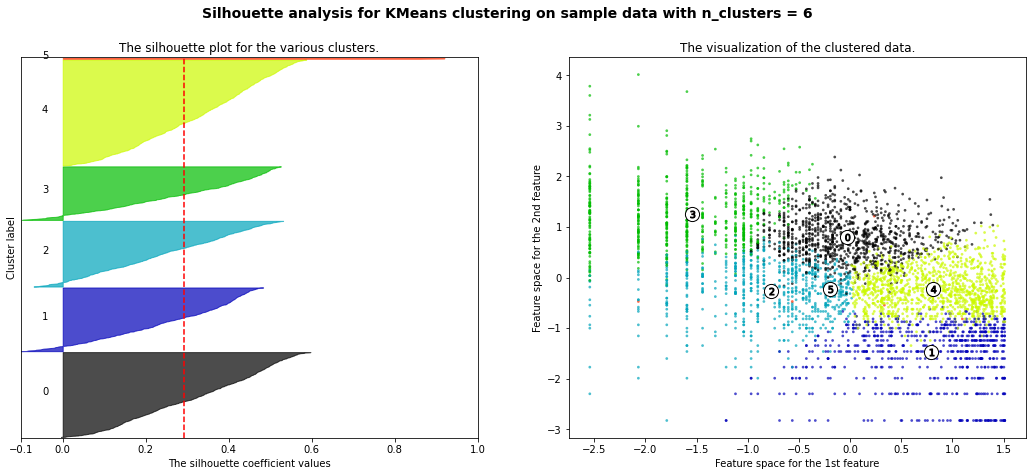

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = datamart_normalized.values

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [32]:
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                        
                    # Assign CustomerID and Cluster as ID variables                  
                    id_vars=['CustomerID', 'Cluster'],

                    # Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
                    # Name the variable and value
                    var_name='Metric', value_name='Value')

datamart_melt.head()

,CustomerID,Cluster,Metric,Value
0,12347,0,Recency,-2.068959
1,12348,1,Recency,0.412035
2,12349,0,Recency,-0.527867
3,12350,1,Recency,1.383450
4,12352,0,Recency,-0.090394


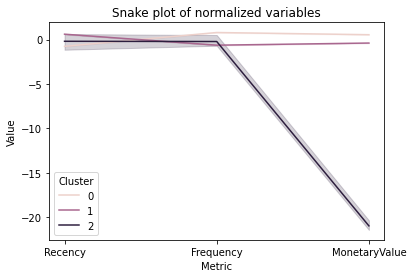

In [33]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()



In [34]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance score rounded to 2 decimals
relative_imp.round(2)



,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.72,0.90,0.93
1,0.58,-0.72,-0.74
2,-0.23,-0.40,-1.00


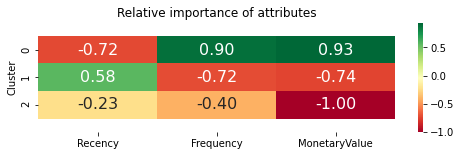

In [35]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', annot_kws={"size": 16})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

